# DAP: Tweak example 2 to follow example 1 (and use the same packages). 

I also need to comment and explain example 3 (auROC) much more thoroughly. 

# Part 1: Kaplan-Meier & Survival curves

There are a number of useful distributions that describe "time until a successful event", including common distributions such as the geometric distribution and the exponential distribution. These distributions are effective at explaining many biological problems and processes **as long as their assumptions are met.** 

In health data, we often are interested in estimating the *'time until death'*, a metric that ends up with so-called **'right censored'** datasets. That is, many individuals join a study, but then some drop out and their information is no longer collected - we don't know if they died or just stopped participating (that is why these are called "right" censored, since the data is thought to start on the left side of the page and time is usually pointing 'right' along the horizontal axis of the page). There is a particular statistical challenge that arises when individual data points in a dataset are **incomplete**. If these censored data points are excluded in the data analysis, the resulting estimator is **biased**, and that is a *HUGE, MASSIVE* problem. Our conventional parametric distributions and estimators rely on assumptions that are not met when data is incomplete. 

As an aside - these are different types of censoring: 
1. Right Censoring: time-to-event is unknown, but it is after some known date. e.g. The 'death' occurs after the end of the study, or there was no follow-up with the patient.
2. Left Censoring: time-to-event is known to be less than a certain duration. e.g. Unknown time of initial infection exposure when first meeting with a patient.
3. Interval Censoring: time-to-event is not directly observed but is known to take place within some time interval.

So: what do we do? 

Enter the Kaplan-Meier estimator. It is a popular non-parametric method across diverse fields (including in medicine) to describe the frequency of survival in particular time frames after a treatment is applied that **accounts for incomplete data**. That is, after chemotherapy to treat a particular type of cancer, a patient might have an X% of survival after Y months.

The KM estimator is used more widely than just in describing survival rates after cancer treatment, but survival after medical treatment is often where individuals first encounter the concept! You have almost certainly seen a KM curve, even if you didn't realize that was what it was called. You can get an overview of KM on Wikipedia: https://en.wikipedia.org/wiki/Kaplan–Meier_estimator

These are the typical questions that KM estimators are used for: 
1. Time to death in biological systems.
2. Failure time in mechanical systems.
3. How long can we expect a user to be on a website / service?
4. Time to recovery for lung cancer treatment.

## Extra Resources: Accessible explanations: 
1. https://datatab.net/tutorial/kaplan-meier-curve
2. https://github.com/lschoe/mpyc/blob/master/demos/KaplanMeierSurvivalExplained.ipynb
3. https://gist.github.com/lindaxiang/d1e32ee2d903e098f6ff

----
# Part 2: AuROC
ROC curve is a graph representing aspects of confusion matrices for a particular machine learning model. For given two ROC curves of a two different machine learning models, the one that has a greater AUC (Area under curve) is considered to be a better machine learning model for the given problem statement at hand. This allows us to pick which model, among >1, is the better model for our data wrt sensitivity and power. 


In [17]:
# If we're running in Colab, install lifelines, a library that makes KM easy. 

#import sys
#IN_COLAB = 'google.colab' in sys.modules

#if IN_COLAB:
#    !pip install lifelines


# Note: I installed this in on my local laptop into my virtual environment which is named "DSTenv"
# 1. Open a terminal
# 2. type: source DSTenv/bin/activate
# 3. type: pip install lifelines

In [2]:
# Load all necessary libraries for Kaplan-Meier Survival Curves
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# we will import the KaplanMeierFitter method from lifelines library
from lifelines import KaplanMeierFitter


# we will import a couple of other common DS libraries for auROC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

# KM estimator:  
# Example 1: How long for a dog to get adopted from a shelter? 

This data set/example is taken from here: https://allendowney.github.io/SurvivalAnalysisPython/02_kaplan_meier.html
This example is a variant of the typical cancer treatment survival curve, which is why I have included it.


Note: this is the "hard way" of doing this -- we aren't using the lifelines package - but this will reveal the logic of the approach to us. We will then use the KaplanMeierFitter from that package so you can see how much easier it is!

In [3]:
# You visit a shelter every week for 10 weeks, and record the arrival time for each dog and the adoption time for each dog that was adopted.

# setting up empty dataframe using DataFrame() from pandas
obs = pd.DataFrame()

# This DataFrame contains one row for each dog and three columns:
# start: arrival time, in weeks since the beginning of the study
obs['start'] = 0,1,2,2,4,6,7
# end: adoption date, for dogs that were adopted, or 9 for dogs that had not been adopted at the end of the study
obs['end'] = 5,2,6,9,9,8,9
# status: 1 for dogs that were adopted; 0 for dogs that were not.
obs['status'] = 1,1,1,0,0,1,0

print(obs)

   start  end  status
0      0    5       1
1      1    2       1
2      2    6       1
3      2    9       0
4      4    9       0
5      6    8       1
6      7    9       0


In [4]:
# this is a function definition that will allow us to plot the data
# I wanted to reduce the number of packages and libraries that needed to be 
# uploaded. You will find, generally, that specific calculations and 
# visualizations will often have a package that will make life easier. 

def plot_lifelines(obs):
    #Plot a line for each observation.
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing, not adopted yet
            # horizontal line at y from start to end in blue
            plt.hlines(y, start, end, color='C0')
        else:
            # complete, adopted out
             # horizontal line at y from start to end in orange
            plt.hlines(y, start, end, color='C1')
            # add a filled in dot to the end of the horizontal line
            plt.plot(end, y, marker='o', color='C1')
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog index')
    # instead of starting from 0 upwards, we start at 6 and go up to 0
    plt.gca().invert_yaxis()

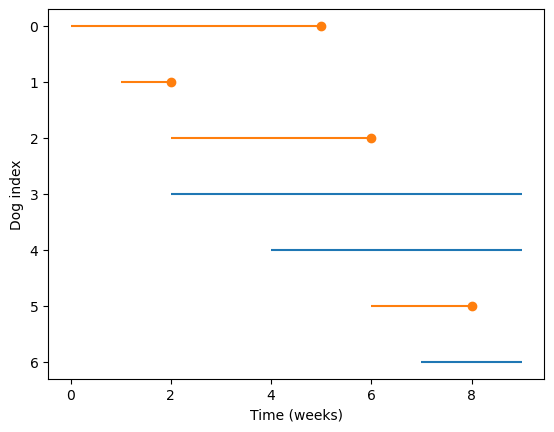

In [5]:
# we will actually CALL the function in this cell.
# Each line represents the time a dog spends at the shelter. Each dot represents an adoption. 
# We can see, for example:
# The dog with index 0 arrived during week 0, and was adopted during week 5.
# The dog with index 3 arrived during week 2, and had not been adopted at the end of week 9.
plot_lifelines(obs)

## Estimating survival
Now suppose we want to know the distribution of “survival time” from arrival to adoption. For the dogs that were adopted, we have all the data we need. For the others, we have only **partial information: if a dog hasn’t been adopted yet, we don’t know when it will be, but we can put a lower bound on it.**

When we have a mixture of complete and incomplete observations – adopted and unadopted dogs – we can’t compute the Survival function directly. Instead, we have to work backwards: 
1. we estimate the **hazard function** first
2. then use it to compute the **survival function, CDF, and PMF.**

Specifically, we’ll use Kaplan-Meier estimation, which is based on two key ideas.

### The first idea is that we can ignore the arrival time in the observed data, and consider only the durations. In effect, we can take the actual lifelines and shift them so they all start at 0, like this:

Text(0.5, 0, 'Duration (weeks)')

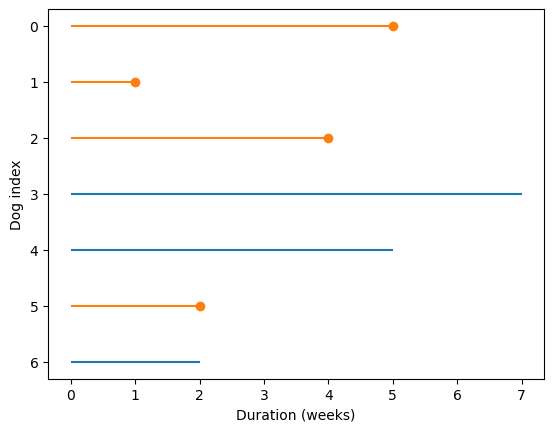

In [6]:
# we only care about duration
duration = obs['end'] - obs['start']
# copying our dataframe into one called shifted so that we don't overwrite the original
shifted = obs.copy()
shifted['start'] = 0
shifted['end'] = duration
# plot - using your function created above - only the durations.
plot_lifelines(shifted)
plt.xlabel('Duration (weeks)')
# Notice that the x-axis in this figure is now duration, not time.

### The second key idea is that we can estimate the hazard function by considering:

The number of dogs adopted at each duration, divided by The number of dogs “at risk” at each duration, where “at risk” means that they could be adopted.

For example:

At duration 1, there is 1 adoption out of 7 dogs at risk, so the hazard rate is 1/7.

At duration 2, there is 1 adoption out of 6 dogs at risk, so the hazard rate is 1/6.

At duration 4, there is 1 adoption out of 4 dogs at risk, so the hazard rate is 1/4.

And so on. Now let’s see how that works computationally.

### Computing "at risk": For each observed duration, we would like to compute the number of dogs that were at risk. 
Here are the unique durations, in order:

In [7]:
# how many durations are there? We can use unique() for this
ts = duration.unique()
# sort them, default is low to high
ts.sort()
#this produces a vector of the times at which dogs are adopted
print(ts)
# To compute the number of dogs at risk, we can loop through ts and count the number of dogs at each time point. 
# here is a series with initial 0 for each ts
at_risk = pd.Series(0, index=ts)
#print(at_risk)
# fill empty at_risk with how many dogs remain in the shelter
for t in ts:
    #print("________________")
    #print(t)
    # for each of the durations [1,2,4,5,6] how many dogs are present?
    k = (t <= shifted['end'])
    #print(k)
    #print("~~~~~~~~~~~~~~~")
    at_risk[t] = k.sum()
print("****************")    
at_risk

[1 2 4 5 7]
****************


1    7
2    6
4    4
5    3
7    1
dtype: int64

In [8]:
# Estimating the hazard function¶
# Now, to compute the hazard function, we need to know the number of dogs adopted at each value of t.
# same strategy as above - set up an empty series and fill it with the values
adopted = pd.Series(0, index=ts)

for t in ts:
    k = (shifted['status'] == 1) & (t == shifted['end'])
    adopted[t] = k.sum()

print("***********")    
print(adopted)
print("***********") 

survival_df=pd.DataFrame()

survival_df['adopted']=adopted
survival_df['at_risk']=at_risk
print(survival_df)
# Finally, the hazard function is the ratio of adopted and at_risk:
survival_df['hazard'] = survival_df['adopted'] / survival_df['at_risk']
print(survival_df)

***********
1    1
2    1
4    1
5    1
7    0
dtype: int64
***********
   adopted  at_risk
1        1        7
2        1        6
4        1        4
5        1        3
7        0        1
   adopted  at_risk    hazard
1        1        7  0.142857
2        1        6  0.166667
4        1        4  0.250000
5        1        3  0.333333
7        0        1  0.000000


# The survival curve
Given the hazard function, we can work backwards to compute the survival curve.

The hazard function is the probability of being adopted at each duration, so its complement is the probability of not being adopted.

In order to survive past t, a dog has to not be adopted at all durations up to and including t.

So the survival function is the cumulative product of the complement of the hazard function.

In [12]:
survival_df['surv'] = (1 - survival_df['hazard']).cumprod()
print(survival_df)
# The CDF is the complement of the survival function
survival_df['cdf'] = 1 - survival_df['surv']
print(survival_df)
#And the PMF is the difference between adjacent elements of the CDF.
survival_df['pmf'] = np.diff(survival_df['cdf'], prepend=0)
survival_df

   adopted  at_risk    hazard      surv
1        1        7  0.142857  0.857143
2        1        6  0.166667  0.714286
4        1        4  0.250000  0.535714
5        1        3  0.333333  0.357143
7        0        1  0.000000  0.357143
   adopted  at_risk    hazard      surv       cdf
1        1        7  0.142857  0.857143  0.142857
2        1        6  0.166667  0.714286  0.285714
4        1        4  0.250000  0.535714  0.464286
5        1        3  0.333333  0.357143  0.642857
7        0        1  0.000000  0.357143  0.642857


,adopted,at_risk,hazard,surv,cdf,pmf
1,1,7,0.142857,0.857143,0.142857,0.142857
2,1,6,0.166667,0.714286,0.285714,0.142857
4,1,4,0.250000,0.535714,0.464286,0.178571
5,1,3,0.333333,0.357143,0.642857,0.178571
7,0,1,0.000000,0.357143,0.642857,0.000000


Kaplan-Meier estimation is available in a library called lifelines. 

In [13]:
kmf = KaplanMeierFitter()

0    5
1    1
2    4
3    7
4    5
5    2
6    2
Name: end, dtype: int64
          KM_estimate
timeline             
0.0          1.000000
1.0          0.857143
2.0          0.714286
4.0          0.535714
5.0          0.357143
7.0          0.357143
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                1.000000                1.000000
1.0                0.334054                0.978561
2.0                0.258154                0.919797
4.0                0.131988                0.824997
5.0                0.051977                0.698713
7.0                0.051977                0.698713


Text(0, 0.5, 'Survival function')

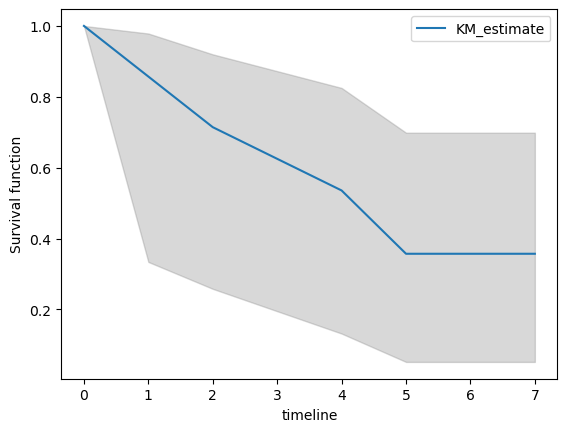

In [14]:
# now we need two sequences, the durations, including complete and ongoing cases.
T = shifted['end']
print(T)
#And an event flag that indicates whether a case is complete.
E = shifted['status']
# The fit method does the KM
kmf.fit(T, E)
# Now the Fitter object contains the estimated survival function.
print(kmf.survival_function_)
# timelines includes an element at t=0, but other than that it is identical to what we computed (except for floating-point error).
max(abs(kmf.survival_function_['KM_estimate'] - survival_df['surv']).dropna())
# lifelines also computes a confidence interval for the survival function.
ci = kmf.confidence_interval_survival_function_
print(ci)
# With such a small dataset, the CI is pretty wide.
ts = ci.index
low, high = np.transpose(ci.values)

plt.fill_between(ts, low, high, color='gray', alpha=0.3)
kmf.survival_function_.plot(ax=plt.gca())
plt.ylabel('Survival function')

## Example 2 (Extra Material):
The following is data that is simulated for two types of leukemia using the values pulled from [here](https://en.wikipedia.org/wiki/Survival_analysis#Example:_Acute_myelogenous_leukemia_survival_data). 

The code was provided by chatGPT with the instructions to not use additional packages -- just regular DS stack (NumPy, Pandas, Matplotlib etc). 

| Type | Wikipedia-reported survival | Parameter we matched | 
|------|---------------------------|----------------------|
| **Acute Myeloid Leukemia (AML)** | 5-year survival ≈ 24 %; median ≈ 8.5 months | monthly hazard λ ≈ 0.024 so that S(60 mo)=0.24 | 
| **Acute Promyelocytic Leukemia (APL)** | ≥ 80 % survival at 10 years (≈ 90 % at 5 years) | λ ≈ 0.004 so that S(60 mo)=0.90 | 

This analysis follows the same steps as with the time until adoption example above.

The analysis does three things: 

1. Simulate patient-level data with exponential survival times drawn so the long-term probabilities in the table hold

2. Follow-up capped at 60 months → right-censoring if a patient “survived” past that.

3. Builds a Kaplan–Meier estimate

In the plot, please note the following two observations:

- how each death makes the step curve drop,

- how censoring leaves the curve flat.

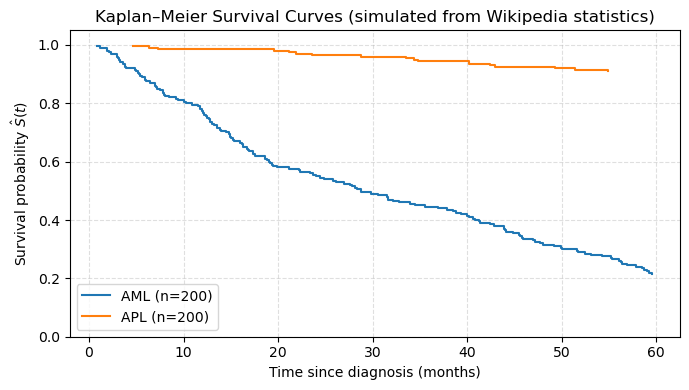

In [15]:
# Kaplan–Meier survival-curve thanks to chatGPT!
# Simulates two leukemia cohorts using survival rates quoted on Wikipedia
# and draws their Kaplan–Meier curves without using any additional libraries beyond the typical DS 'stack'
# 1. Acute Myeloid Leukemia (AML): ~24 % 5-year survival
# 2. Acute Promyelocytic Leukemia (APL): ~90 % 5-year survival


# --------------------------------------------------------------------------- #
# 1. Kaplan–Meier estimator implemented “from scratch”
# --------------------------------------------------------------------------- #
def km_estimate(times, events):
    #Compute the Kaplan–Meier survival function S(t).
    #Parameters - note similarity to example 1 (adoption times in shelter)
    #----------
    #times: 1-D event or censoring times 
    #events: 1-D boolean (True = event occurred, False = censored)
    
    #Returns
    #-------
    #unique_event_times : 1-D array of times where at least one event occurred
    #survival_probs     : survival probability at each of those times
    
    # Sort by time so the math is straightforward
    order = np.argsort(times)
    times_sorted  = times[order]
    events_sorted = events[order]

    # Unique times at which events (deaths) actually occurred
    unique_event_times = np.unique(times_sorted[events_sorted])

    n_at_risk = len(times_sorted)        # patients still under follow-up
    surv_prob = 1.0                      
    surv_probs = []

    for t in unique_event_times:
        # Number of events (deaths) at time t
        d_i = np.sum((times_sorted == t) & events_sorted)
        # Number censored exactly at time t
        c_i = np.sum((times_sorted == t) & (~events_sorted))

        # Kaplan–Meier step: multiply by (1 – dᵢ / nᵢ)
        #Kaplan–Meier math:
        # For every unique death time t we multiply the running survival estimate by
        # 1 – (deaths at t) / (patients still under observation just before t).
        surv_prob *= (1.0 - d_i / n_at_risk)
        surv_probs.append(surv_prob)

        # Update risk set size
        n_at_risk -= (d_i + c_i)

    return unique_event_times, np.array(surv_probs)


# --------------------------------------------------------------------------- #
# 2. Simulate individual-level survival times from Wikipedia summary stats
# --------------------------------------------------------------------------- #
rng = np.random.default_rng(seed=42)   # reproducible

n_patients   = 200     # per cohort
follow_up    = 60      # months of observation (5 years)

# ----- Acute Myeloid Leukemia (AML) ---------------------------------------- #
# Want S(60 mo) ≈ 0.24  →  λ = −ln(0.24) / 60
lambda_aml = -np.log(0.24) / follow_up
aml_times  = rng.exponential(scale=1 / lambda_aml, size=n_patients)
aml_events = aml_times <= follow_up          # True if died before censor date
aml_times  = np.minimum(aml_times, follow_up)

# ----- Acute Promyelocytic Leukemia (APL) ---------------------------------- #
# Want S(60 mo) ≈ 0.90  →  λ = −ln(0.90) / 60
lambda_apl = -np.log(0.90) / follow_up
apl_times  = rng.exponential(scale=1 / lambda_apl, size=n_patients)
apl_events = apl_times <= follow_up
apl_times  = np.minimum(apl_times, follow_up)


# --------------------------------------------------------------------------- #
# 3. Build Kaplan–Meier curves
# --------------------------------------------------------------------------- #
t_aml, s_aml = km_estimate(aml_times, aml_events)
t_apl, s_apl = km_estimate(apl_times, apl_events)


# --------------------------------------------------------------------------- #
# 4. Plot
# --------------------------------------------------------------------------- #
plt.figure(figsize=(7, 4))
#A simple plt.step makes the staircase curve. Each drop corresponds to an observed death; 
#flat stretches with no drops mean only censored observations occurred there.
plt.step(t_aml, s_aml, where="post", label=f"AML (n={n_patients})")
plt.step(t_apl, s_apl, where="post", label=f"APL (n={n_patients})")

plt.xlabel("Time since diagnosis (months)")
plt.ylabel("Survival probability $\\hat S(t)$")
plt.title("Kaplan–Meier Survival Curves (simulated from Wikipedia statistics)")
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


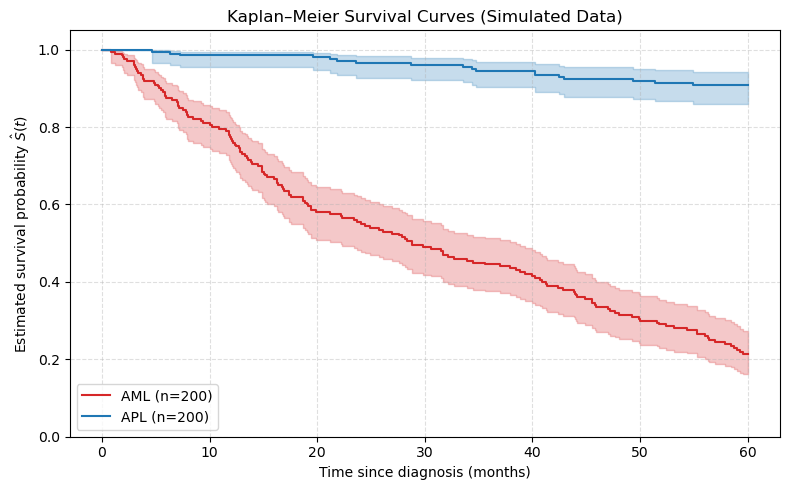

In [16]:
# you can repeat the same analysis but using the lifelines KaplanMeierFitter
# There is so much less code now!

# --------------------------------------------------------------------------- #
# 1. Simulate survival data for two leukemia subtypes
# --------------------------------------------------------------------------- #

# Set a random seed for reproducibility
rng = np.random.default_rng(seed=42)

# Number of patients per group
n_patients = 200

# Total follow-up period in months (5 years)
follow_up = 60

# --------------------------------------------------------------------------- #
# Acute Myeloid Leukemia (AML)
# 5-year survival ≈ 24% implies exponential survival with λ such that:
#     S(t) = exp(-λt) → λ = -ln(S) / t
# --------------------------------------------------------------------------- #
lambda_aml = -np.log(0.24) / follow_up

# Generate event times from exponential distribution
aml_times = rng.exponential(scale=1 / lambda_aml, size=n_patients)

# Determine if event (death) occurred before censoring
aml_events = aml_times <= follow_up

# Apply right-censoring at the follow-up time
aml_times = np.minimum(aml_times, follow_up)

# --------------------------------------------------------------------------- #
# Acute Promyelocytic Leukemia (APL)
# 5-year survival ≈ 90% → λ = -ln(0.90) / 60
# --------------------------------------------------------------------------- #
lambda_apl = -np.log(0.90) / follow_up
apl_times = rng.exponential(scale=1 / lambda_apl, size=n_patients)
apl_events = apl_times <= follow_up
apl_times = np.minimum(apl_times, follow_up)

# --------------------------------------------------------------------------- #
# 2. Use lifelines KaplanMeierFitter to estimate survival curves
# --------------------------------------------------------------------------- #

# Instantiate the KaplanMeierFitter
kmf_aml = KaplanMeierFitter()
kmf_apl = KaplanMeierFitter()

# Fit the Kaplan–Meier estimator for AML data
kmf_aml.fit(durations=aml_times, event_observed=aml_events, label="AML (n=200)")

# Fit the Kaplan–Meier estimator for APL data
kmf_apl.fit(durations=apl_times, event_observed=apl_events, label="APL (n=200)")

# --------------------------------------------------------------------------- #
# 3. Plot survival curves
# --------------------------------------------------------------------------- #

plt.figure(figsize=(8, 5))

# Plot AML survival curve
kmf_aml.plot_survival_function(ci_show=True, linestyle='-', color='tab:red')

# Plot APL survival curve
kmf_apl.plot_survival_function(ci_show=True, linestyle='-', color='tab:blue')

# Configure the plot
plt.title("Kaplan–Meier Survival Curves (Simulated Data)")
plt.xlabel("Time since diagnosis (months)")
plt.ylabel("Estimated survival probability $\\hat S(t)$")
plt.grid(True, linestyle="--", alpha=0.4)
plt.ylim(0, 1.05)
plt.tight_layout()

# Show the plot
plt.show()


## AuROC example
This example is from [here](https://github.com/akshaykapoor347/Compute-AUC-ROC-from-scratch-python/blob/master/AUCROCPython.ipynb)

For a deeper dive into the intuition, interpretation, and construction of AuROC try [this](https://www.kaggle.com/code/arezalo/ml-studytime-1-roc-curve-auc)

auROC on the test set: 0.932


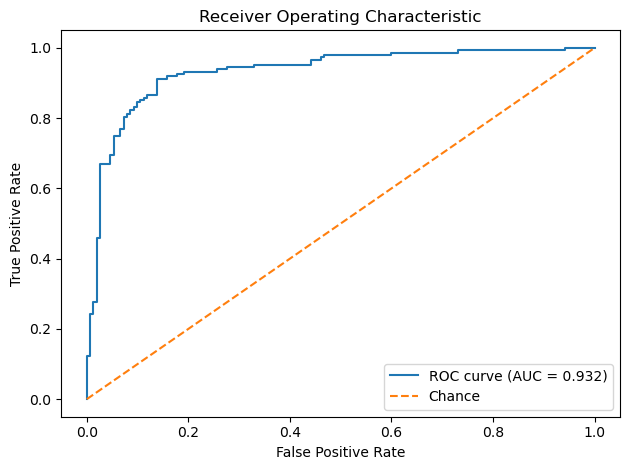

In [17]:
# 1. Create a simulated binary-classification dataset
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    weights=[0.5, 0.5],  # balanced classes
    random_state=42,
)

# 2. Train/test split to evaluate auROC on unseen data. The test_size is 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Train a simple model (Logistic Regression)
# Model fit: a plain ol' logistic-regression model learns class-membership probabilities.
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 4. Get predicted probabilities for the positive class
# Score extraction: predict_proba returns a probability for each class
# slicing [:, 1] grabs only the positive-class scores the ROC needs.
y_scores = clf.predict_proba(X_test)[:, 1]

# 5. Compute ROC curve and auROC
#ROC coordinates:
# roc_curve sweeps every possible decision threshold to compute (FPR, TPR) pairs.
fpr, tpr, _ = roc_curve(y_test, y_scores)
#auROC – roc_auc_score integrates those points; 0.50 is chance, 1.0 is perfect.
auc_value = roc_auc_score(y_test, y_scores)
print(f"auROC on the test set: {auc_value:.3f}")

# 6. Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Extra material for auROC:
I have stolen the aSAH dataset that is available in a R (programming language) package called pROC (I usually use it to teach auROC in R). This is the paper it is [from](https://link.springer.com/article/10.1007/s00134-009-1641-y)

It's a classic dataset for ROC analysis, especially to compare *Glasgow Coma Score (GCS)* and *WFNS* as predictors of survival after aneurysmal subarachnoid hemorrhage. The dataset contains:

- gos6: Glasgow Coma Score (numeric)
- wfns: World Federation of Neurosurgical Societies grade (ordinal)
- age: Patient age
- ndka - neuron spefic dimer biomarker
- s100b: S100B biomarker level
- outcome: Binary survival outcome ("Good" or "Poor")


Each ROC curve shows how well that variable discriminates between patients with poor vs good outcomes. An AUC close to 1.0 = excellent predictor, 0.5 = no better than chance.

   gos6 outcome  gender  age  wfns  s100b   ndka
0     5    Good  Female   42     1   0.13   3.01
1     5    Good  Female   37     1   0.14   8.54
2     5    Good  Female   42     1   0.10   8.09
3     5    Good  Female   27     1   0.04  10.42
4     1    Poor  Female   42     3   0.13  17.40
     gos6 outcome  gender  age  wfns  s100b   ndka  outcome_bin
0       5    Good  Female   42     1   0.13   3.01            0
1       5    Good  Female   37     1   0.14   8.54            0
2       5    Good  Female   42     1   0.10   8.09            0
3       5    Good  Female   27     1   0.04  10.42            0
4       1    Poor  Female   42     3   0.13  17.40            1
..    ...     ...     ...  ...   ...    ...    ...          ...
108     4    Good    Male   53     4   0.17  13.87            0
109     1    Poor    Male   58     5   0.44  15.89            1
110     5    Good  Female   32     1   0.15  22.43            0
111     5    Good  Female   39     1   0.50   6.79            0
11

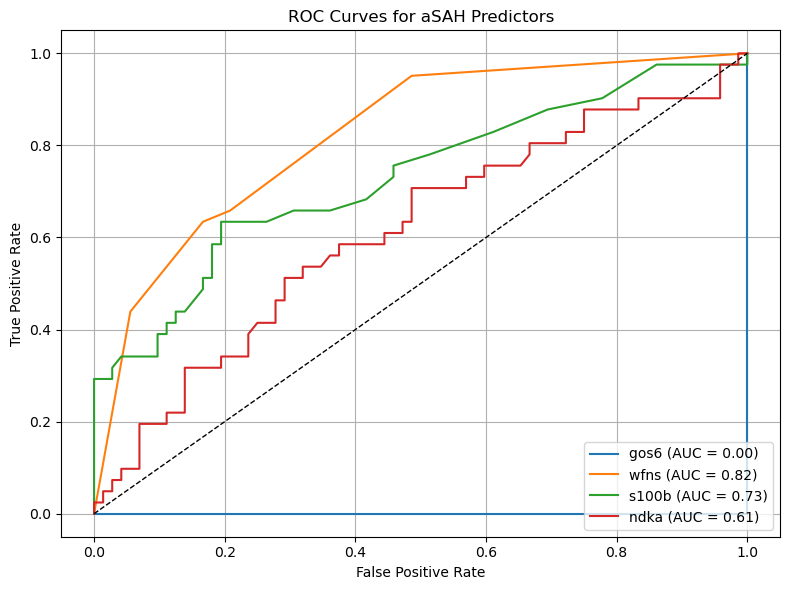

In [18]:
# Step 1: Load the dataset (aSAH.csv taken from pROC::aSAH)

df_asah = pd.read_csv("aSAH.csv")

# Preview
print(df_asah.head())

# Step 2: Clean and Prep Data. 
# Convert outcome to binary: Good = 0 (survived), Poor = 1 (died)
df_asah['outcome_bin'] = df_asah['outcome'].map({'Good': 0, 'Poor': 1})
# ensure we have added an outcome bin
print(df_asah)

# Step 3: ROC analysis. define a function. 
def plot_roc(predictor_name, df, ax):
   # Extract predictor and outcome for gos6,'wfns', 's100b', 'ndka' 
    y_true = df['outcome_bin']
    y_scores = df[predictor_name]

    # Drop NA values
    valid = ~df[predictor_name].isna()
    y_true = y_true[valid]
    y_scores = y_scores[valid]

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    ax.plot(fpr, tpr, label=f"{predictor_name} (AUC = {auc:.2f})")

# call the plot_roc function created above. 
fig, ax = plt.subplots(figsize=(8, 6))

# Predictors to analyze
predictors = ['gos6','wfns', 's100b', 'ndka']

# Plot each ROC curve
for predictor in predictors:
    plot_roc(predictor, df_asah, ax)

# Diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', lw=1)


# Plot ROC curves
ax.set_title("ROC Curves for aSAH Predictors")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.grid(True)
plt.tight_layout()
plt.show()

As a predictor, wfns has the best dicrimination between patients with good versus bad outcomes. 